In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from PIL import Image, ImageDraw, ImageFont
from concurrent.futures import ProcessPoolExecutor

In [22]:
IMG_PATH, DATA_PATH

(PosixPath('/home/giles/Documents/kaggle/higgsml'), PosixPath('../data'))

In [2]:
!python ../modules/data_import.py -d {DATA_PATH} -f PRI_jet_num -r True -z True -y True

Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates
Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 30 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_met_pt']
Running train
Saving fold: 

In [3]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
cont_feats = feats['cont_feats']
cat_feats = feats['cat_feats']    
cat_maps = feats['cat_maps']  
cat_szs = feats['cat_szs']  
train_feats = cont_feats + cat_feats

In [4]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')

In [5]:
df = train_fy.get_df(inc_inputs=True, deprocess=True); len(df); df.head()

200000 candidates loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,109.102997,61.176998,76.580002,59.290001,0.000,0.000000,0.000,3.135,17.427000,121.709999,...,0.000000,0.000000,27.754999,20.293108,-25.913437,32.415176,41.500000,1.0,1,0.000027
1,181.341995,70.253998,127.005989,2.171000,0.000,0.000000,0.000,3.494,2.171001,95.045998,...,0.000000,0.000000,57.259998,89.156906,-21.388142,-3.724448,21.709999,0.0,0,0.000169
2,103.282997,17.708000,69.484001,67.527000,0.000,0.000000,0.000,2.436,24.891001,130.563004,...,0.000000,0.000000,50.464001,94.160362,26.598667,13.211420,29.698999,1.0,0,0.000051
3,103.834000,21.393000,43.523998,312.742004,0.715,245.985992,0.134,0.674,56.143002,530.862000,...,61.189461,-109.277321,49.068001,116.437958,179.089020,41.177582,183.761993,3.0,0,0.000009
4,92.636002,21.025999,60.842999,150.233002,4.067,482.888000,-3.070,1.284,16.861000,236.300003,...,11.334548,-434.685791,64.210999,234.337982,53.694386,19.539154,57.139000,2.0,0,0.000002


In [6]:
font = ImageFont.truetype("arial.ttf", 13)

In [7]:
def event2img(event:np.ndarray, size:int=224) -> PIL.Image.Image:
    img = Image.fromarray(np.zeros([size,size,3]), 'RGB')
    for i, f in enumerate(event):
        ImageDraw.Draw(img).text(((0.25+(i%2))*size//2,(i//2)*2*size//len(event)), f'{f:.3f}', fill=(255,255,255), font=font)
    return img

CPU times: user 42.2 ms, sys: 4.78 ms, total: 47 ms
Wall time: 46.3 ms


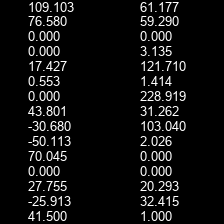

In [8]:
%%time
event2img(df[train_feats].values[0])

In [9]:
for mode in ['train', 'val', 'test']: os.makedirs(IMG_PATH/'images'/mode, exist_ok=True)

In [10]:
def save_image(event:np.ndarray, name:Union[str, int, float], loc:Path, size:int=224) -> None:
    img = event2img(event, size)
    name = str(name)
    if '.' not in name: name += '.png'
    img.save(loc/name)

In [11]:
def proc_sample(df:pd.DataFrame, mode:str, size:int=224) -> None:
    func = partial(save_image, loc=IMG_PATH/'images'/mode, size=size)
    with ProcessPoolExecutor(10) as e: e.map(func, df[train_feats].values, df.index.values)

In [12]:
%%time
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True, deprocess=True)
proc_sample(train_df, 'train')

200000 candidates loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


CPU times: user 50.6 s, sys: 5.21 s, total: 55.8 s
Wall time: 2min 38s


In [13]:
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'image_name'}, inplace=True)
train_df.to_csv(IMG_PATH/'train.csv', index=False)

In [17]:
%%time
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"), cont_feats, cat_feats)
val_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
val_df = val_fy.get_df(inc_inputs=True, deprocess=True)
proc_sample(val_df, 'val')

50000 candidates loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


CPU times: user 12.7 s, sys: 1.37 s, total: 14.1 s
Wall time: 39.2 s


In [18]:
val_df.reset_index(inplace=True)
val_df.rename(columns={'index':'image_name'}, inplace=True)
val_df.to_csv(IMG_PATH/'val.csv', index=False)

In [19]:
%%time
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"), cont_feats, cat_feats)
test_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
test_df = test_fy.get_df(inc_inputs=True, deprocess=True)
test_df['private'] = test_fy.get_column('private')
proc_sample(test_df, 'test')

550000 candidates loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


CPU times: user 2min 19s, sys: 13 s, total: 2min 32s
Wall time: 7min 38s


In [20]:
test_df.reset_index(inplace=True)
test_df.rename(columns={'index':'image_name'}, inplace=True)
test_df.to_csv(IMG_PATH/'test.csv', index=False)